In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import math as m
from collections import defaultdict

In [2]:
from ranking_funcs import read_imdb_actor_data,Comp_Greedy_Algo_backdoor,get_prob_backdoor_opt,rec_row_prob_back,backdoor_adjustment_opt,find_backdoor_sets_opt,Greedy_Algo,get_most_probable_elements,get_cgm,get_prob_backdoor_opt,get_probs,get_prob_backdoor,filter_prob_df_grouped,read_data,get_ranking_query_prob_grouped,get_stable_ranking_opt,get_ranking_query,get_ranking_query_prob,get_test_revert_ranking_rec,get_new_G,filter_prob_df,calc_prob,base_line

/Users/wangning/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- Television Series:'tvSeries','tvMiniSeries'

- Television Specials:'tvSpecial','tvMovie','tvShort','tvEpisode'

- Film Content:'movie'

- Short Formats:'short'

- Interactive/Other Formats:'video','videoGame'

In [3]:
df=read_imdb_actor_data('ranking_data_sets/cleaned_imdb_name.csv')
df.head()

,primaryName,tconst_x,averageRating,numVotes,titleType,primaryTitle,isAdult,runtimeMinutes
0,2,tt0159163,8.0,2,0,The Expert,0,3
1,2,tt0057757,8.0,3,0,The Human Jungle,0,3
2,2,tt0159897,7.0,2,0,The Newcomers,0,2
3,2,tt0064030,7.0,3,2,Anne of the Thousand Days,0,3
4,2,tt0103460,6.0,3,0,Kung Fu: The Legend Continues,0,3


- primaryName might influence the type of titles they are in, which could affect ratings. So, primaryName → titleType → averageRating.
- primaryName might influence the viewership of a title, potentially affecting the number of votes. More popular actors might attract more attention to a title, indirectly influencing its rating through increased visibility or expectations. So, primaryName → numVotes → averageRating.
- The length of the content might be tailored or selected based on the actor's typical roles or preferences, which could then influence ratings. So, primaryName → runtimeMinutes → averageRating.
- Whether a film is intended for adults might be influenced by the typical roles or image of an actor, which could then influence its rating. So, primaryName → isAdult → averageRating.


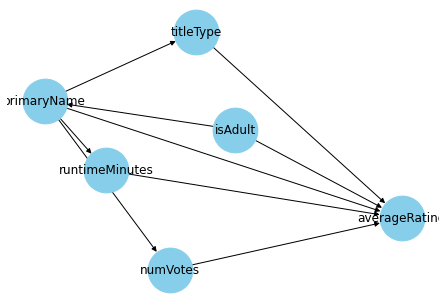

In [4]:
G = nx.DiGraph()

nodes = ["averageRating", "numVotes", "titleType", "isAdult", "runtimeMinutes", "primaryName"]
G.add_nodes_from(nodes)

edges = [
    ("primaryName", "averageRating"), 
    ("primaryName", "titleType"),     
    ("titleType", "averageRating"),
    ("primaryName", "numVotes"),
    ("numVotes", "averageRating"),
    ("primaryName", "runtimeMinutes"),
    ("runtimeMinutes", "averageRating"),
    ("isAdult", "primaryName"),
    ("isAdult", "averageRating")
]
G.add_edges_from(edges)

nx.draw(G, with_labels=True, node_color='skyblue', node_size=2000, edge_cmap=plt.cm.Blues)
plt.show()

In [5]:
new_G=get_new_G(G,df)

In [6]:
nds=["isAdult", "runtimeMinutes", "averageRating", "primaryName"]

In [7]:
for n in nds:
    print((n,find_backdoor_sets_opt(G, "averageRating", n)))

('isAdult', None)
('runtimeMinutes', [frozenset({'primaryName'})])
('averageRating', None)
('primaryName', [frozenset({'isAdult'})])


In [8]:
df.sort_values(by='averageRating',ascending=False).head(10)

,primaryName,tconst_x,averageRating,numVotes,titleType,primaryTitle,isAdult,runtimeMinutes
192,2,tt11524214,10.0,1,0,Water Helps the Blood Run,0,2
964,2,tt6057470,10.0,0,3,The Last Visit,0,2
819,0,tt10846308,10.0,0,3,Divided We Stand,0,2
971,0,tt7586230,10.0,0,3,Tertium Quid,0,2
834,1,tt3507346,10.0,0,3,Haiti Speaks,0,3
970,0,tt7586230,10.0,0,3,Tertium Quid,0,2
301,2,tt1334307,9.0,3,0,Unsung,0,3
968,0,tt4574590,9.0,0,3,Det Lyse Mørket,0,2
642,1,tt0353049,9.0,3,0,Chappelle's Show,0,2
568,2,tt1470691,9.0,0,2,The Kings,0,3


In [9]:
get_ranking_query(new_G, df, 10, {'primaryName':4}, 'averageRating', {'primaryName':2}, opt="fix")

,primaryName,tconst_x,averageRating,numVotes,titleType,primaryTitle,isAdult,runtimeMinutes
819,0,tt10846308,10.0000,0.000000,3.000000,Divided We Stand,0,2.000000
834,1,tt3507346,10.0000,0.000000,3.000000,Haiti Speaks,0,3.000000
970,0,tt7586230,10.0000,0.000000,3.000000,Tertium Quid,0,2.000000
971,0,tt7586230,10.0000,0.000000,3.000000,Tertium Quid,0,2.000000
964,4,tt6057470,9.9081,0.040043,2.939955,The Last Visit,0,2.030573
192,4,tt11524214,9.9081,1.040043,-0.060045,Water Helps the Blood Run,0,2.030573
487,1,tt1118666,9.0000,0.000000,3.000000,Departure,0,1.000000
504,0,tt1266540,9.0000,0.000000,3.000000,Beheading of a Smiling Dog,0,1.000000
957,3,tt4508902,9.0000,3.000000,0.000000,One Punch Man,0,2.000000
63,1,tt0239352,9.0000,2.000000,1.000000,Don Giovanni,0,3.000000


- Firstly, we see that the tvSeries Water Helps the Blood Run has the highest average rating 10. After we update the actor from Michael Smith to David Brown. We see it becomes to 9.9081 which is the 5th.

In [10]:
add more actors famous in movies
create new one only in movies

SyntaxError: invalid syntax (2184108957.py, line 1)

In [ ]:
popular_actors=['Michael Smith',
                'David Smith',
                'Michael Johnson',
                'Chris Smith',
                'David Brown'
                'David Jones']

In [ ]:
df_bo=get_prob_backdoor_opt(new_G, df, 5, {'primaryName':0}, 'averageRating', {'primaryName':1}, 'fix', [819,971], 10)

df_bo

In [ ]:
var=['runtimeMinutes']
df_gr=Greedy_Algo(new_G, df, 5, 'averageRating',var,0, None,100, opt="add",force=2)
df_gr

In [ ]:
row_indexes=[834]
greedy_backdoor=Comp_Greedy_Algo_backdoor(row_indexes,new_G, df, 5, 'averageRating',var,1, None ,100, opt="add",force=2)

In [ ]:
j=1
for i in greedy_backdoor:
    j*=i
print(j)

In [ ]:
df[df['primaryName']==1]

In [ ]:
df[df['runtimeMinutes']==3]

In [ ]:
df.iloc[834]

In [ ]:
mean_value = sum(greedy_backdoor) / len(greedy_backdoor)
print(mean_value)

In [ ]:
df[df['runtimeMinutes'] == 2]


In [ ]:
def k_range_backdoor(G, df, k, update_vars, target_column, condition, opt, row_indexes,end_k):
    back_result=[]
    for z in range(k,end_k+1):
        updated_df=get_ranking_query(G, df, len(df), update_vars, target_column, condition, opt).sort_values(by=target_column,ascending=False)
        theta=updated_df[target_column].iloc[z-1]
        back_result.append(get_prob_backdoor_opt(G, df, z, update_vars,
                                                 target_column, condition, opt, row_indexes, theta))
    return back_result
        

In [ ]:
k_range_backdoor_val=k_range_backdoor(new_G, df, 5, {'primaryName':0}, 'averageRating', {'primaryName':2}, 'fix', [819,971],1000)

In [ ]:
x_values = range(5, 1001)     
plt.plot(x_values, k_range_backdoor_val)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

def data_size_backdoor(G, df, k, update_vars, target_column, condition, opt, row_indexes, n_splits, random_state):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    df_dropped = df.drop(row_indexes)
    
    folds = []
    for _, test_index in kf.split(df_dropped):
        fold_data = df_dropped.iloc[test_index]
        folds.append(fold_data)
    
    selected_rows = df.loc[row_indexes]

    data = pd.concat([selected_rows, folds[0]], axis=0)
    
    back_result = []
    back_result_len = []
    for i in range(1, len(folds)):
        data = pd.concat([data, folds[i]], axis=0)
        
        if condition and not set(condition.keys()).issubset(data.columns):
            update_vars = None
        
        updated_df=get_ranking_query(G, data, len(data), update_vars, target_column, condition, opt).sort_values(by=target_column,ascending=False)
        theta=updated_df[target_column].iloc[k-1]
        back_result_len.append(len(updated_df))
        back_result.append(get_prob_backdoor_opt(G, data, k, update_vars,
                                                 target_column, condition, opt, row_indexes, theta))
        
    return back_result_len,back_result



In [ ]:
lenth,data_size_backdoor_val=data_size_backdoor(new_G, df, 5, {'primaryName':0}, 'averageRating', {'primaryName':2}, 'fix', [819,971],100,123)

In [ ]:
plt.plot(lenth, data_size_backdoor_val)
plt.show()

Variations. In the experiments, HypeR is run assuming that background knowledge about the causal graph is known a priori. We
consider one variation where the causal model is not available (denoted by HypeR-NB), and another where we perform sampling for
training the regressor (denoted HypeR-sampled).

In [ ]:
popular_actors=['Michael Smith',
                'David Smith',
                'Michael Johnson',
                'Chris Smith',
                'David Brown'
                'David Jones']

baseline is naiive approach

variations

add descrption of datasets

quality of solutions(compare the expectation, different metrics(precision k (calculate everything to the naiive approach)))

Run time for solutions (time bar plot)

what is difference result from the two different definitions


IMDB(data set)

add more actors famous in movies

create new one only in movies


## Experiment

### Datasets 

We give a short description of the datasets and baselines used in
this section.
- German dataset [20] contains details of bank account holders including demographic and financial information along with their credit risk. It composed of a single table and the
causal graph was used from [11].

- Amazon book dataset contains details of books in computer area including publication and edition information along with their ratings. The causal graph was generated from ChatGPt.

- IMDB dataset contains details of movies and television works including the eposides length and actor information along with their ratings. The causal garph was generated from ChatGPt.

### Methods

#### Overview of Hypothetical Update 
The foundation of our approach was the construction and utilization of a causal graph, derived from the dataset using Ordinary Least Squares (OLS) regression. This step was crucial in identifying and mapping out the causal relationships between various variables within the dataset. With the causal graph established, we  proceeded to apply a technique we termed "hypothetical update." This involved systematically altering specific variables within the database, following predetermined scenarios. The purpose of these updates was twofold: firstly, to simulate the impact of potential real-world changes within the data environment, and secondly, to observe and meticulously record the shifts in the top k results arising from these hypothetical changes. This approach was instrumental in allowing us to predict the effects of variable manipulation, offering valuable insights into the causal dynamics at play within the dataset.

#### Overview of Stable Ranking 
Our stable ranking analysis was predicated on a robust and iterative algorithmic process. The objective was to critically examine the resilience and consistency of the ranking system in response to ongoing modifications of a chosen variable. To this end, we developed the `get_stable_ranking_opt` algorithm, which was designed to be highly adaptable, allowing for a variety of operations on the variable under scrutiny (such as fixing, multiplying, dividing, adding, and subtracting). Central to this methodology was the recursive function `test_revert_ranking_rec`. This function facilitated repeated and controlled adjustments to the variable, enabling us to analyze the stability of the rankings over multiple iterations, under an array of distinct conditions and scenarios. The ultimate goal was to ascertain the robustness of the ranking mechanism and its susceptibility to changes in variable states.

#### Overview of Group Ranking 
In our group ranking strategy, we shifted our focus from individual to group-based rankings. This method involved segmenting entities into groups based on shared characteristics, then analyzing the rankings within these groups. This approach was particularly advantageous in datasets where group attributes significantly influenced ranking outcomes. By categorizing items into distinct groups and evaluating the rankings therein, we were able to uncover deeper insights and patterns that might remain concealed in individual rankings. This group-based analysis allowed for a more granular understanding of the data, revealing how group characteristics can impact overall ranking dynamics.

#### Overview of Greedy Algorithm & Backdoor Criterion
To further explore the intricacies of ranking changes, we implemented a greedy algorithm. This iterative method involved continuously updating a chosen variable and closely monitoring the resultant shifts in ranking. The aim was to capture the immediate and incremental impacts of these variable changes on the overall ranking structure. Complementing this approach, we employed the backdoor criterion. This sophisticated statistical technique was used to calculate the probabilities of certain rankings occurring. It took into account indirect causal paths (backdoor paths) within the causal graph. By incorporating this criterion, we were able to provide a more comprehensive and nuanced understanding of ranking probabilities under a variety of scenarios and conditions.



### Results

#### Results of Hypothetical Update
IMDB. In our experiment with the IMDB dataset, we simulated a scenario where the lead actor of the high-rated TV series "Water Helps the Blood Run" was changed. The original actor, Michael Smith, was hypothetically replaced with David Brown. This change provided a unique opportunity to study the impact of cast changes on a show's popularity and viewer ratings. We meticulously monitored the average ratings before and after this alteration. Initially, the series enjoyed a top rating of 10. However, post-replacement, the average rating intriguingly dropped to 9.9081, resulting in a decline in its ranking from first to fifth place. This outcome was particularly insightful, highlighting the significant role an actor plays in the success and viewership of a TV series.

Amazon. We focused on the price variable of first edition books. By uniformly adjusting their prices to $5, we observed the consequent shifts in their rankings. Remarkably, the book 'C# & C++', which initially dominated the ratings, was superseded by 'Learning EBF' following the price adjustment. This outcome was instrumental in highlighting how price alterations can significantly sway consumer preferences and affect book rankings, providing valuable insights into market dynamics and consumer behavior in the book industry.


#### Results of Stable Ranking 
Amazon. The experiment centered around the variable 'runtimeMinutes' for TV series. We systematically increased this duration by adding twice its standard deviation in a series of 100 iterations. The objective was to monitor the evolution of the top 5 ranking indices of TV series with each incremental change. Employing the backdoor criterion, we calculated the probability of each ranking index's appearance in the top 5 over these iterations. The findings from this experiment were crucial in elucidating the relationship between episode length and a series' ranking, offering a nuanced understanding of viewer preferences in relation to content duration.


#### Results of Group Ranking 
Amazon. Our approach entailed categorizing books based on their editions and specifically targeting second edition books for a price increase. We doubled the prices and calculated the probability for every possible ranking permutation within this subgroup. This detailed analysis was aimed at discerning the impact of edition-specific pricing strategies on the overall ranking within a book dataset. The results from this investigation were significant in demonstrating how subtle changes within a specific group can ripple through the entire ranking system, altering the competitive landscape.

#### Results of Greedy Algorithm & Backdoor Criterion

German. In this part of the study, we focused on the 'credit' variable, incrementally increasing it by 0.5 times its standard deviation. During each iteration, we recorded the top 5 ranking indices and observed that a particular sequence of indices ([0, 619, 604, 605, 606]) appeared consistently across 100 iterations. Utilizing the backdoor criterion, we computed the probability of this specific ranking sequence's occurrence in the top 5 for each iteration. This intensive analysis provided a deeper insight into the credit variable's influence on ranking outcomes.


IMDB. The experiment involved continuously adjusting the 'runtimeMinutes' variable by adding twice its standard deviation. This process was repeated across numerous iterations, during which we meticulously recorded the top 5 ranking indices. The persistence of a certain ranking sequence ([192, 819, 971, 834, 970]) across all iterations was a key finding. By applying the backdoor criterion, we calculated an exceedingly low probability (1.764976e-292) of the specific index 834 appearing in the top 5 rankings. This analysis was instrumental in understanding the impact of runtime variations on the rankings of shows and movies.

#### K range backdoor criterion

For the same update, we calculate the probility of ranking in top k by continously updating the k.

IMDB. We experimented with a range of k values, from 5 to 1000, while updating the ranking by changing the lead actor from Michael Smith to Michael Johnson. A significant observation was the monotonically increasing probability of the ranking as k increased. This trend was prominently displayed in Figure 10, providing a clear visual representation of the relationship between the range of k and the likelihood of a particular ranking.


#### data size backdoor criterion

For the same update, we calculate the probility of ranking in top k by continously changing the datasize.

IMDB. We divided the dataset into 100 folds to analyze the effect of data size on ranking probability. We calculated the probability of a specific ranking (induced by changing the actor from Michael Smith to Michael Johnson) in the top k, iterating from a single fold to all 100 folds. The results demonstrated a generally decreasing trend in probability with increasing data size. This finding suggests that larger datasets tend to stabilize and reduce the likelihood of fluctuations in rankings due to changes in a single variable, offering critical insights into the role of data size in predictive analytics.